In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.constants import c
import os.path as path
#! pip install cupy
# Import modules from OptiCommPy
from optic.utils import parameters, dBm2W
from optic.models.devices import basicLaserModel, mzm, edfa, photodiode
from optic.dsp.core import firFilter, lowPassFIR, pulseShape, upsample, signal_power, pnorm
#from optic.dsp.coreGPU import checkGPU
from optic.models.channels import linearFiberChannel
from optic.plot import eyediagram
from optic.comm.metrics import bert, theoryBER, calcLinOSNR
from optic.models.amplification import edfaSM, OSA, edfaArgs
from optic.comm.modulation import modulateGray
from tqdm.notebook import tqdm

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

ModuleNotFoundError: No module named 'numpy'

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

figsize(10, 3)

In [3]:
# System parameters
SpS = 16 #symbols per sample
Rs = 5e9  # Bit rate in bits per second (5 Gb/s)
Fs = SpS*Rs # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period
seq_len = 2**10   # PRBS sequence length
np.random.seed(seed=123) # fixing the seed to get reproducible results

# --- Transmitter Parameters
Ptx_dBm = 0         # Optical Transmit Power in dBm (for initial plots)
Pi = dBm2W(Ptx_dBm) # convert optical transmit power from dBm to W
lambda_c = 1550e-9  # Wavelength in meters
Fc = c / lambda_c   # Center frequency

# # Laser
# paramLaser = parameters()
# paramLaser.power_dbm = Ptx_dBm # Laser power in dBm
# paramLaser.Fs = Fs
# paramLaser.Ns = SpS * seq_len
# paramLaser.lambda_c = lambda_c # Wavelength in meters
# optical_field = basicLaserModel(paramLaser)
# print(f"Generated CW Laser field of shape: {optical_field.shape}")

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi / 2 # for OOK modulation

# --- Fiber Channel Parameters
paramCh = parameters()
paramCh.L = 50            # Fiber length in meters (50 km)
paramCh.alpha = 0.2       # Attenuation in dB/km
paramCh.D = 16            # Dispersion in ps/nm/km
paramCh.Fc = Fc           # carrier frequency
paramCh.Fs = Fs           # sampling frequency [samples/s]

# --- EDFA Parameters (Full Model)

paramEDFA = parameters()
paramEDFA.type = "AGC"    # Automatic Gain Control
paramEDFA.value = paramCh.alpha * paramCh.L # Target Gain = 10 dB
paramEDFA.NF = 5.0        # Noise Figure in dB
paramEDFA.Fc = paramCh.Fc # central optical frequency
paramEDFA.Fs = Fs         # sampling frequency [asmples/s]

# PID controller parameters for gain control
paramEDFA.kp = 2e-3
paramEDFA.ki = 0
paramEDFA.kd = 0

# Pump laser info
paramEDFA.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
paramEDFA.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}

# Giles parameters file
paramEDFA.file = 'giles_MP980.dat'
paramEDFA.fileunit = 'nm'
paramEDFA.gmtc = 'Bessel'
paramEDFA.tol = 0.05
paramEDFA.tolCtrl = 0.5

# ASE
paramEDFA.noiseBand= 1.25e9

if 'google.colab' in str(get_ipython()):
  paramEDFA.file = path.join(path.abspath(path.join("/content/OptiCommPy/")), 'optic', 'models', 'ampParams', paramEDFA.file)
else:
  paramEDFA.file = path.join(path.abspath(path.join("../")), 'optic', 'models', 'ampParams', paramEDFA.file)


# --- EDFA Parameters (simple Model) manualy set noise figure NF
paramEDFA_ana = parameters()
paramEDFA_ana.G = paramCh.alpha * paramCh.L # 10 dB Gain
paramEDFA_ana.NF = 5.0      # 5 dB Noise Figure
paramEDFA_ana.Fc = Fc       # central optical frequency
paramEDFA_ana.Fs = Fs       # sampling frequency [asmples/s]

# --- Receiver Parameters
# Ideal Photodiode (for main analysis as per exercise)
paramPD_ideal = parameters()
paramPD_ideal.ideal = True
paramPD_ideal.R = 1.0
paramPD_ideal.Fs = Fs

# Non-Ideal Photodiode (for additional analysis)
paramPD_noisy = parameters()
paramPD_noisy.ideal = False
paramPD_noisy.R = 1.0
paramPD_noisy.Fs = Fs
paramPD_noisy.B = Rs * 0.75 # Electrical bandwidth. real world frequency response of the photodiode


Generated NRZ electrical signal of shape: (31,)
Transmitter output field shape: (1600000,)
Average power of the modulated optical signal [mW]: 0.501 mW
Average power of the modulated optical signal [dBm]: -2.999 dBm


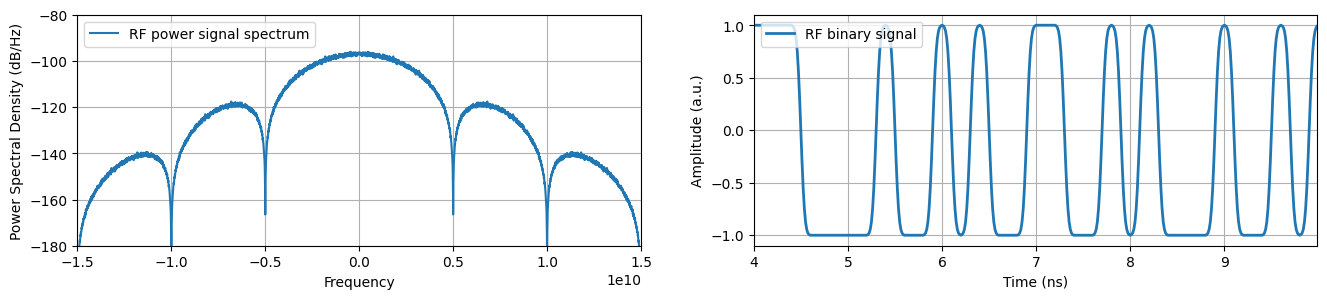

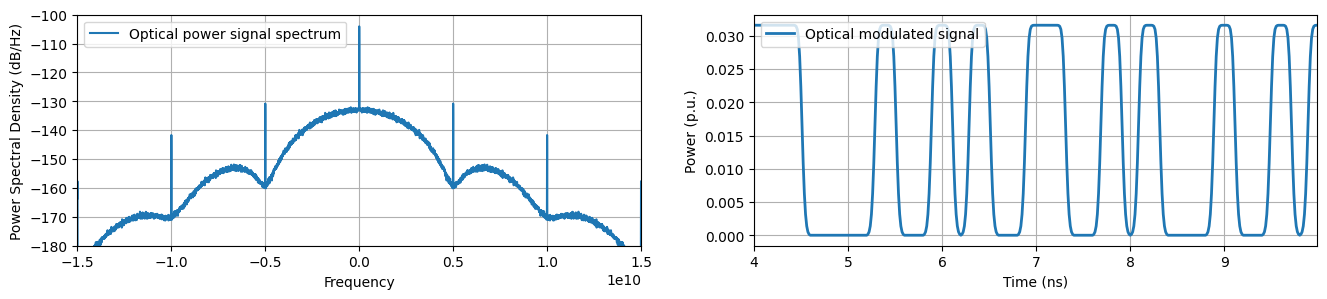

In [11]:
# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=100000)
n = np.arange(0, bitsTx.size)

# map bits to electrical pulses
symbTx = 2 * bitsTx - 1 #modulateGray(bitsTx, 2, 'pam') #bipolar NRZ
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# Generate NRZ electrical signal
# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))
print(f"Generated NRZ electrical signal of shape: {pulse.shape}")

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)
print(f"Transmitter output field shape: {sigTxo.shape}")

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(SpS*20,SpS*50) # from symbol 20 to 50
t = interval*Ts/1e-9 # samples_indices_array * sample_period / 1e-9 for nanoseconds. this step maps the samples to their occurance time

# Plot Electrical Driving Signal
# plot psd (power spectral density)
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*(2**10), sides='twosided', label = 'RF power signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-100);
axs[0].psd(sigTxo, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical power signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTxo[interval], label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

Sample rate [THz]: 0.080
Time window [ns]:  20000.000
Central wavelength [nm]: 1550.00
Simulation window  [nm]: 0.641110 - [1549.68 nm - 1550.32 nm]
Frequency spacing [GHz]: 0.000050
Number of points: 1600000
Number of modes: 1
Average power - TX [mW] : 0.498 mW
Average power - TX [dBm] : -3.026 dBm


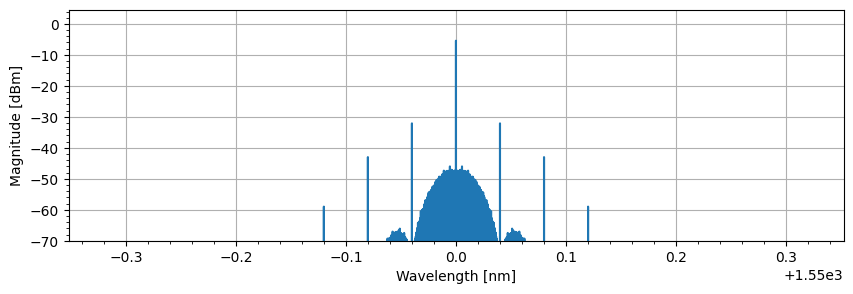

In [10]:
Nmodes = 1     # number of modes
sigTxo_reshaped = np.reshape(sigTxo, (len(sigTxo), Nmodes))
lenFrqSg, isy = np.shape(sigTxo_reshaped)
simOpticalBand = (Fs*(c/Fc)**2)/c # frequency bandwidth into the equivalent wavelength bandwidth
tx_pw = np.sum(1000*np.mean(sigTxo_reshaped * np.conj(sigTxo_reshaped), axis = 0).real)

# information TX
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*lenFrqSg/Fs))
print('Central wavelength [nm]: %6.2f' %(1e9*c/Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]'
      %(1e9*simOpticalBand, 1e9*(c/Fc-simOpticalBand/2), 1e9*(c/Fc+simOpticalBand/2)))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/lenFrqSg))
print('Number of points: %d' %(lenFrqSg))
print('Number of modes: %d' %(Nmodes))
print('Average power - TX [mW] : %.3f mW' %(tx_pw))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(tx_pw)))

OSA(sigTxo_reshaped, Fs, Fc); # optical spectrum analyzer of the signal. absolute optical power at different wavelengths

Transmitted optical field shape: (1600000,)

--- OSA before EDFA ---


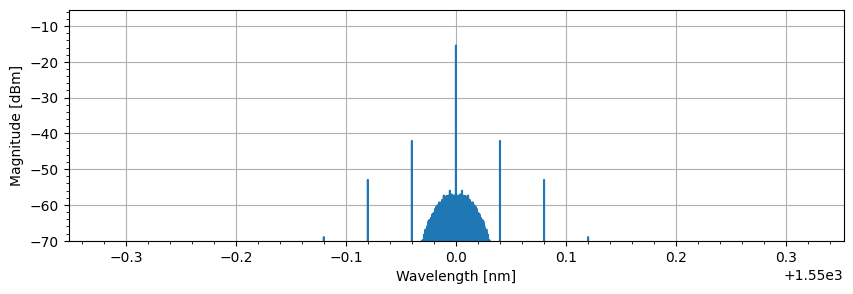

Transmitted optical field shape: (1600000,)

--- OSA after EDFA ---


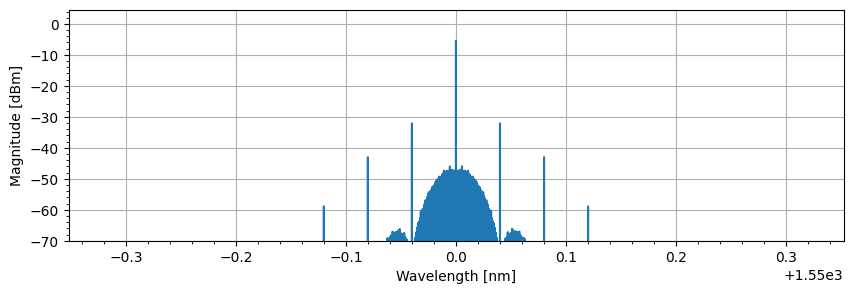

In [11]:
# detailed EDFA model (single run. high tx power)
# Fiber Propagation
Eo_fiber = linearFiberChannel(sigTxo, paramCh)
print(f"Transmitted optical field shape: {Eo_fiber.shape}")

Eo_fiber_2D = np.reshape(Eo_fiber, (len(Eo_fiber), 1))
print("\n--- OSA before EDFA ---")
OSA(Eo_fiber_2D, Fs, Fc);
plt.show()

# EDFA amplification
Ei_edfa = Eo_fiber
Eo_edfa = edfa(Ei_edfa, paramEDFA_ana) # using the simple model and not the edfaSM because the rxercise secifies the noise figure (no need for physics calculation here)
print(f"Transmitted optical field shape: {Eo_edfa.shape}")

# Reshape Eo_edfa to be 2D for the OSA function
Eo_edfa_2D = np.reshape(Eo_edfa, (len(Eo_edfa), 1))

print("\n--- OSA after EDFA ---")
OSA(Eo_edfa_2D, Fs, Fc);
plt.show()

Received electrical signal shape: (1600000,)


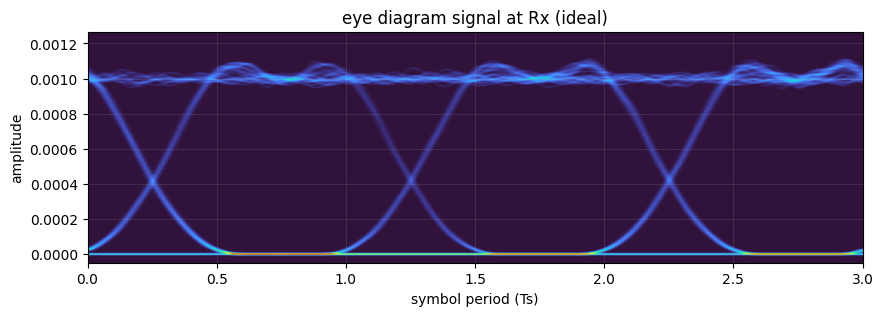

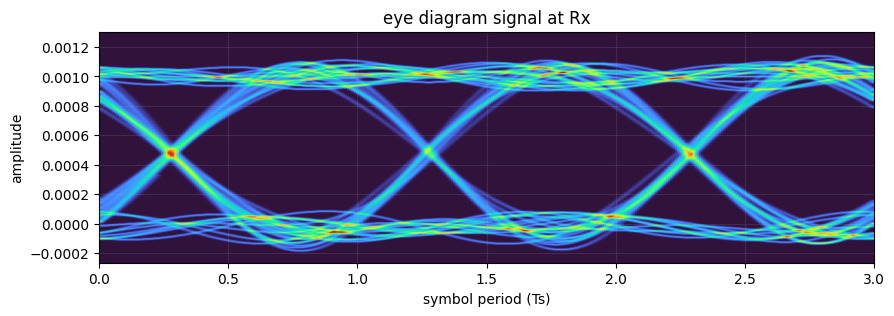

I0 = -0.10 
I1 = 2.22 
σ0 = 0.12 
σ1 = 0.12 
Optimal decision threshold Id = 1.08 
Q = 9.51 

Filtered signal shape: (1600000,)


In [12]:
I_Rx_ideal = photodiode(Eo_edfa.real, paramPD_ideal)
print(f"Received electrical signal shape: {I_Rx_ideal.shape}")

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
I_Rx = photodiode(Eo_edfa.real, paramPD_noisy)

# Low-Pass Filtering (Bessel Filter)
# Filters out noise before decision/sampling. (optional)
cutoff_freq = 0.75 * Rs # preserve the signal's original bandwidth. reject higher frequencies (noise)
filt_coeffs = lowPassFIR(cutoff_freq, Fs, 1000,typeF='rect') * np.sqrt(2)
I_Rx_filt = firFilter(filt_coeffs, I_Rx)

discard = 100

eyediagram(I_Rx_ideal[discard:-discard].copy(), I_Rx_ideal.size-2*discard, SpS, plotlabel='signal at Rx (ideal)', ptype='fancy')
eyediagram(I_Rx[discard:-discard].copy(), I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I_Rx = I_Rx/np.std(I_Rx) # the signal has a consistent power level
                         # (a standard deviation of 1.0) regardless of any gain or loss it experienced in the channel.

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS] # each bit is represented by 16 indices (samples).
                    # to determine if the bit is 0 or 1 we only need to look to the amplitude of the bit (the "decision instant")
                    # we trim it down to the useful samples (every 16 indices). these are the symbol's amplitudes

# get received signal statistics
I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

print(f"Filtered signal shape: {I_Rx_filt.shape}")

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 9.52e-22 


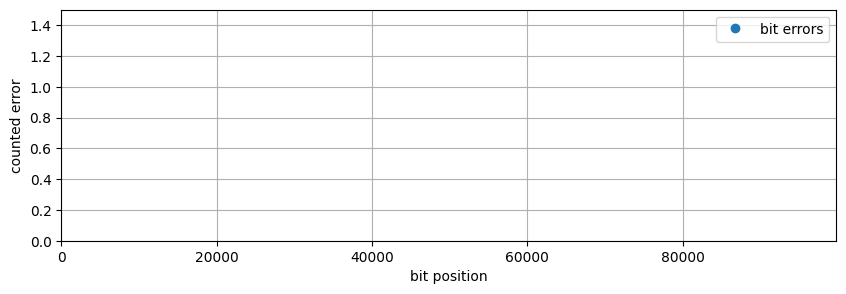

In [13]:
# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

In [75]:
# detailed edfa model for different tx powers
print("\n--- Receiver Sensitivity Analysis ---")

tx_powers_dBm = np.arange(-25, -12, 0.5)
BER = np.zeros(tx_powers_dBm.shape)
ber_results = []
discard = 100

for indPi, p_dbm in enumerate(tqdm(tx_powers_dBm)):
    p_w = dBm2W(p_dbm)

    # --- Run full simulation ---
    Ai_loop = np.sqrt(p_w)
    sigTxo_loop = mzm(Ai_loop, sigTx, paramMZM)
    Eo_Fiber_loop = linearFiberChannel(sigTxo_loop, paramCh)

    # Use the  edfa model for the sweep
    Eo_edfa_loop = edfa(Eo_Fiber_loop, paramEDFA)

    I_Rx_loop = photodiode(Eo_edfa_loop, paramPD_ideal)
    I_Rx_loop = I_Rx_loop/np.std(I_Rx_loop)

    # BER calculation
    I_Rx_samp_loop = I_Rx_loop[0::SpS]
    bitsRx = np.empty_like(bitsTx)
    I1_loop = np.mean(I_Rx_samp_loop[bitsTx==1])
    I0_loop = np.mean(I_Rx_samp_loop[bitsTx==0])
    Id_loop = (I1_loop + I0_loop) / 2

    bitsRx[I_Rx_samp_loop > Id_loop] = 1
    bitsRx[I_Rx_samp_loop <= Id_loop] = 0
    errors = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indPi] = np.mean(errors)
    #ber_results.append(ber if ber > 0 else 1e-12)



--- Receiver Sensitivity Analysis ---


  0%|          | 0/26 [00:00<?, ?it/s]

/tmp/ipython-input-84-1238645012.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(tx_powers_dBm, np.log10(BER), 'o-', label='Simulated BER (EDFA)')


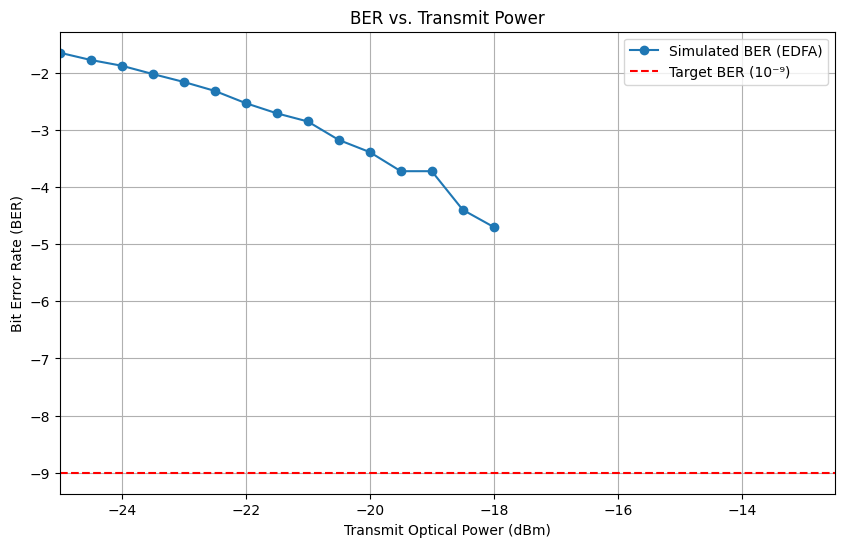

Receiver sensitivity is the transmit power (dBm) at which the BER curve crosses the 10⁻⁹ line.


In [84]:
# --- Plot BER vs. Transmit Power ---
plt.figure(figsize=(10, 6))
#plt.semilogy(tx_powers_dBm, ber_results, 'o-', label='Simulated BER (Ideal Photodiode)')
plt.plot(tx_powers_dBm, np.log10(BER), 'o-', label='Simulated BER (EDFA)')
plt.axhline(y=np.log10(1e-9), color='r', linestyle='--', label='Target BER (10⁻⁹)')
plt.xlabel('Transmit Optical Power (dBm)');
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs. Transmit Power');
plt.grid(True, which="both");
plt.legend();
#plt.ylim(1e-13, 1)
plt.xlim(min(tx_powers_dBm), max(tx_powers_dBm))
plt.show()

# --- Determine Receiver Sensitivity ---
print("Receiver sensitivity is the transmit power (dBm) at which the BER curve crosses the 10⁻⁹ line.")

In [ ]:
Ei_edfa = Eo_fiber
Ei_edfa_reshaped = np.reshape(Ei_edfa, (len(Ei_edfa), 1))
Eout, PumpF, PumpB, noisef = edfaSM(Ei_edfa_reshaped, Fs, Fc, paramEDFA)

INFO:root:
EDF absorption and gain coeficients. Calculating absorption and emission cross-section ...
INFO:root:EDFA SM: loop  1
INFO:root:Convergence: 0.061%.

INFO:root:EDFA SM: control loop  1
INFO:root:Convergence: 27.552 dB
INFO:root:Pump for.: 50.00 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -99.829%.

INFO:root:EDFA SM: loop  2
INFO:root:Convergence: 0.764%.

INFO:root:EDFA SM: control loop  2
INFO:root:Convergence: 24.804 dB
INFO:root:Pump for.: 25.00 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -98.503%.

INFO:root:EDFA SM: loop  2
INFO:root:Convergence: -0.042%.

INFO:root:EDFA SM: control loop  3
INFO:root:Convergence: 21.045 dB
INFO:root:Pump for.: 12.50 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -100.125%.

INFO:root:EDFA SM: loop  2
INFO:root:Convergence: -0.097%.

INFO:root:EDFA SM: control loop  4
INFO:root:Convergence: 16.086 dB
INFO:root:Pump for.:  6.25 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -100.279%.

INFO:root:EDFA SM:

In [ ]:
rx_pw = np.sum(1000*np.mean(Eout * np.conj(Eout), axis = 0).real)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/tx_pw)))

OSA(Eout, Fs, Fc);

In [ ]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_Amp_ideal = photodiode(Eout[:,0].real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx_Amp = photodiode(Eout[:,0].real, paramPD)

discard = 100

eyediagram(I_Rx_Amp_ideal[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx_Amp[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I_Rx_Amp = I_Rx_Amp/np.std(I_Rx_Amp)

# capture samples in the middle of signaling intervals
I_Rx_Amp = I_Rx_Amp[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx_Amp[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx_Amp[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx_Amp[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx_Amp[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx_Amp> Id] = 1
bitsRx[I_Rx_Amp<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size)